## Imports

In [43]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
filepath = 'data/logins.json'

with open(filepath, "r") as f:
    logins = json.load(f)

In [3]:
#view data structure. Only 1 entry point in json: login_time
logins['login_time'][:5]

['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

In [4]:
# save down to just the raw data, not having the nested json
login_data = logins['login_time']
login_data[:5]

['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

In [5]:
#Load to a pandas df
login_df = pd.DataFrame(login_data, columns=['login_time'])
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
#check dtypes to make sure it really is a timestamp
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [7]:
#convert using the to_datetime function
login_df['login_time'] = pd.to_datetime(login_df['login_time'])

In [8]:
#validate
print(login_df.head())
print('--'*50)
print(login_df.info())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


## Initial Exploration

In [9]:
login_df.shape

(93142, 1)

In [10]:
#look for abnormal amount of logins
login_df['login_time'].value_counts()

1970-03-17 01:01:39    3
1970-01-06 21:45:52    3
1970-03-29 03:24:57    3
1970-04-12 04:03:15    3
1970-04-04 01:17:40    3
                      ..
1970-02-13 21:05:25    1
1970-02-13 21:10:52    1
1970-02-13 21:20:04    1
1970-02-13 21:12:19    1
1970-04-13 18:54:23    1
Name: login_time, Length: 92265, dtype: int64

I'm surprised to see any duplicates down to the second, but it is not out of the realm of possibility and the max is only 3.

In [11]:
#when is the first login
login_df['login_time'].min()

Timestamp('1970-01-01 20:12:16')

In [12]:
#when is the most recent login?
login_df['login_time'].max()

Timestamp('1970-04-13 18:57:38')

In [13]:
#any blanks?
login_df.isnull().sum()

login_time    0
dtype: int64

## Aggregate Data

Convert this data into a count of logins in 15-minute intervals.

### Prep and Perform Resampling to Aggregate

In [14]:
#set the login_time as the index
login_df.set_index('login_time', inplace=True)

#add a count column
login_df['logins'] = 1

#resample
login_15 = login_df.resample('15T').sum()

In [15]:
login_15.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## Further Exploration

### EDA Cleaning Review

Explore data and look for any issues.

In [16]:
#view shape
login_15.shape

(9788, 1)

In [17]:
#any NAs after resampiing?
login_15.isnull().sum()

logins    0
dtype: int64

In [18]:
#any duplicate login_time bins?
login_15[login_15.index.duplicated()]

,logins
login_time,


In [19]:
#summary statistics
login_15.describe()

,logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


### Distribution and Boxplot

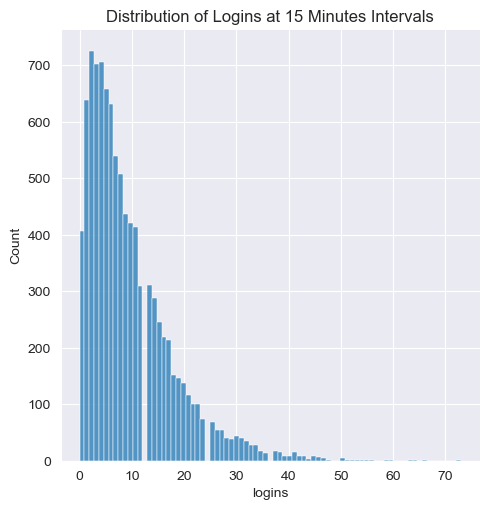

In [20]:
sns.set_style("darkgrid")

sns.displot(login_15, x='logins')

plt.title('Distribution of Logins at 15 Minutes Intervals')
plt.show()

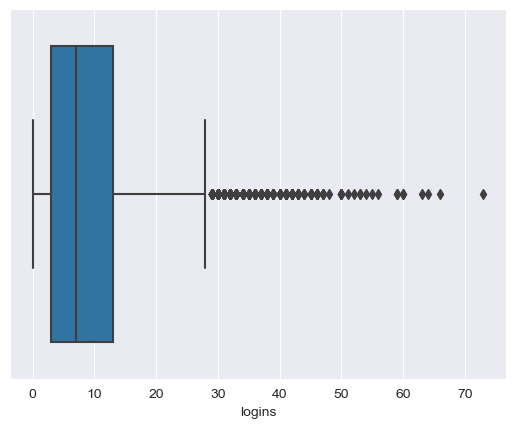

In [21]:
sns.boxplot(x=login_15['logins'])
plt.show()

**Observations**
The distribution is highly skewed, and we can see those outliers show up in the box plot. Without knowing more about the source of the data, I will chock that up to specific demand peaks which I'll now explore more.

## Visualizaiton

Explore the data more to try to better understand and explain.

### Long-term Trend

In [22]:
#promote index for simpler x,y calls
login_15.reset_index(inplace=True)

In [23]:
login_15.head()

,login_time,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [24]:
login_15.columns

Index(['login_time', 'logins'], dtype='object')

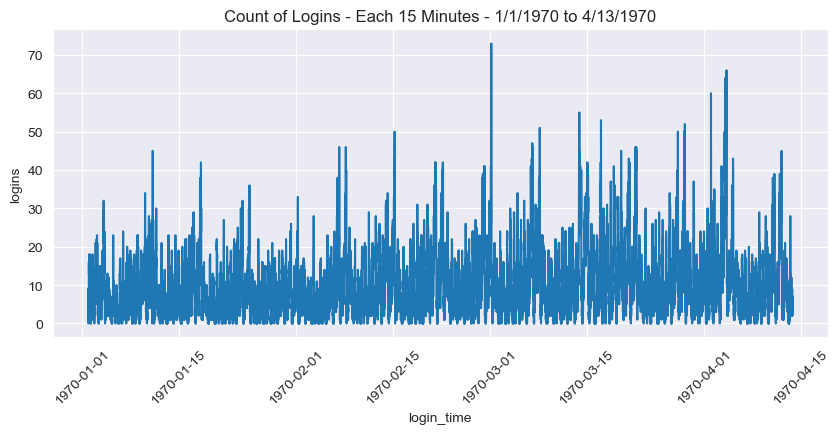

In [25]:
plt.figure(figsize=(10,4))

sns.lineplot(x='login_time', y='logins', data=login_15)

plt.title('Count of Logins - Each 15 Minutes - 1/1/1970 to 4/13/1970')
plt.xticks(rotation=45)

plt.show()

There are obviously fluctuations, but I do feel like I see some recurring trends within batches of dates/times I want to explore more. First I'm curious how this looks by day and then day of week.

### View Trend by Day

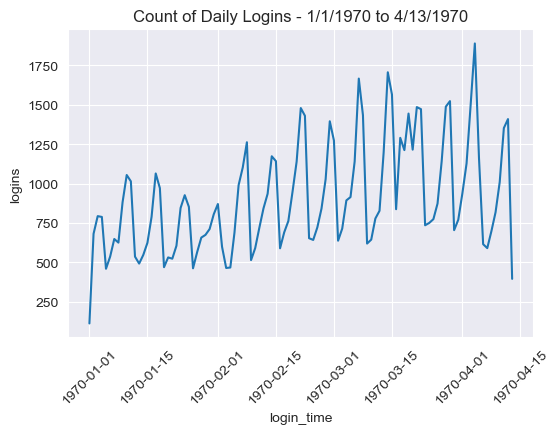

In [26]:
#resample
login_daily = login_df.resample('D').sum()

#promot index
login_daily.reset_index(inplace=True)

#graph
plt.figure(figsize=(6,4))

sns.lineplot(x='login_time', y='logins', data=login_daily)

plt.title('Count of Daily Logins - 1/1/1970 to 4/13/1970')
plt.xticks(rotation=45)

plt.show()

There looks to be some periodic spikes, likely with certain days of the week. I'll check that weekday view as well.

### Day of Week Average

In [27]:
login_daily

,login_time,logins
0,1970-01-01,112
1,1970-01-02,681
2,1970-01-03,793
3,1970-01-04,788
4,1970-01-05,459
...,...,...
98,1970-04-09,818
99,1970-04-10,1009
100,1970-04-11,1352
101,1970-04-12,1409


In [28]:
#add weekday to daily dataframe
login_daily['weekday'] = login_daily['login_time'].dt.day_name()

#groupby weekday
login_weekday = login_daily.groupby('weekday', as_index=False)['logins'].mean()

#change title
login_weekday.rename(columns={'logins': 'login_avg'}, inplace=True)

login_weekday.head(7)

,weekday,login_avg
0,Friday,1013.866667
1,Monday,588.200000
2,Saturday,1291.800000
3,Sunday,1211.133333
4,Thursday,797.333333
5,Tuesday,662.000000
6,Wednesday,738.500000


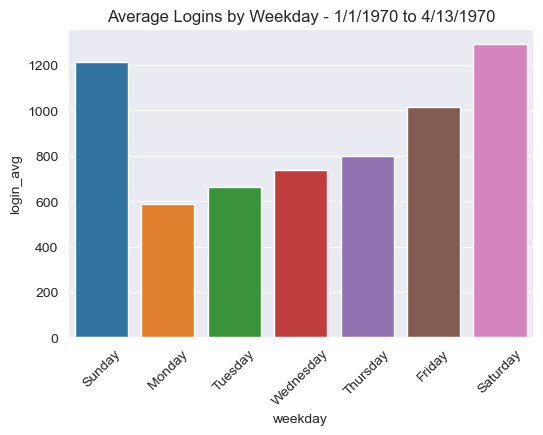

In [29]:
#graph
plt.figure(figsize=(6,4))

sns.barplot(x='weekday', y='login_avg', data=login_weekday, order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

plt.title('Average Logins by Weekday - 1/1/1970 to 4/13/1970')
plt.xticks(rotation=45)

plt.show()

On average, demand spikes on Saturdays, and overall are at the highest level on the weekends. There is steady growth from Monday through to Saturday. Now I'm curious how demand looks based on the time of day.

### Daily Demand Cycle

I want to look at the average cycle per day, but also incorporating the day of the week. I picture a graph with each weekday down the rows and then time increments along the columns with a heatmap of average demand. Let's try it.

In [30]:
#re-familiarize with the login_15 dataframe
login_15.head()

,login_time,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [31]:
#add weekday to this dataframe
login_15['weekday'] = login_15['login_time'].dt.day_name()

login_15.head()

,login_time,logins,weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [32]:
#breakout the time from the datetime
login_15['time'] = login_15['login_time'].dt.hour

login_15.head()

,login_time,logins,weekday,time
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [49]:
login_day_hour = login_15[['logins','weekday','time']].rename(columns={'time': 'hour'})

login_day_hour.head()

,logins,weekday,hour
0,2,Thursday,20
1,6,Thursday,20
2,9,Thursday,20
3,7,Thursday,20
4,1,Thursday,21


In [56]:
#convert weekday text to corresponding integer
login_day_hour.loc[login_day_hour.weekday == 'Sunday', 'weekday'] = 1
login_day_hour.loc[login_day_hour.weekday == 'Monday', 'weekday'] = 2
login_day_hour.loc[login_day_hour.weekday == 'Tuesday', 'weekday'] = 3
login_day_hour.loc[login_day_hour.weekday == 'Wednesday', 'weekday'] = 4
login_day_hour.loc[login_day_hour.weekday == 'Thursday', 'weekday'] = 5
login_day_hour.loc[login_day_hour.weekday == 'Friday', 'weekday'] = 6
login_day_hour.loc[login_day_hour.weekday == 'Saturday', 'weekday'] = 7

In [57]:
#save new series with grouped avgerage logins and then unstack
out = login_day_hour.groupby(['weekday','hour'])['logins'].mean().unstack()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
1,18.716667,22.583333,26.800000,27.450000,35.116667,18.366667,6.366667,3.200000,2.550000,3.000000,...,13.100000,13.366667,13.633333,10.300000,9.283333,10.533333,10.200000,10.416667,9.716667,9.283333
2,8.850000,6.900000,5.200000,3.933333,3.433333,2.016667,1.100000,1.850000,2.450000,4.266667,...,5.616667,4.883333,4.150000,3.966667,4.450000,4.678571,6.714286,10.803571,10.910714,9.500000
3,10.839286,10.107143,7.035714,3.535714,2.660714,2.017857,0.821429,1.142857,1.571429,4.321429,...,5.517857,4.410714,3.910714,3.267857,5.410714,5.375000,8.714286,12.571429,13.535714,12.928571
4,12.267857,12.250000,8.607143,5.339286,4.375000,2.410714,0.857143,1.500000,1.767857,4.285714,...,5.696429,4.696429,3.821429,3.428571,5.125000,5.464286,8.928571,13.196429,15.803571,16.214286
5,14.571429,13.875000,11.160714,6.696429,4.553571,2.428571,1.196429,1.446429,1.696429,4.482143,...,6.928571,5.000000,4.321429,4.142857,6.267857,7.000000,10.366667,14.500000,18.150000,17.216667
6,16.250000,15.950000,12.850000,8.366667,5.883333,4.083333,2.016667,1.750000,1.816667,4.000000,...,8.700000,6.500000,6.200000,8.000000,9.616667,10.966667,13.383333,20.100000,25.316667,21.633333
7,20.900000,26.033333,26.800000,26.233333,28.650000,18.216667,6.800000,2.966667,2.116667,1.966667,...,12.750000,12.716667,11.966667,10.683333,10.633333,11.400000,11.700000,14.566667,19.366667,16.766667


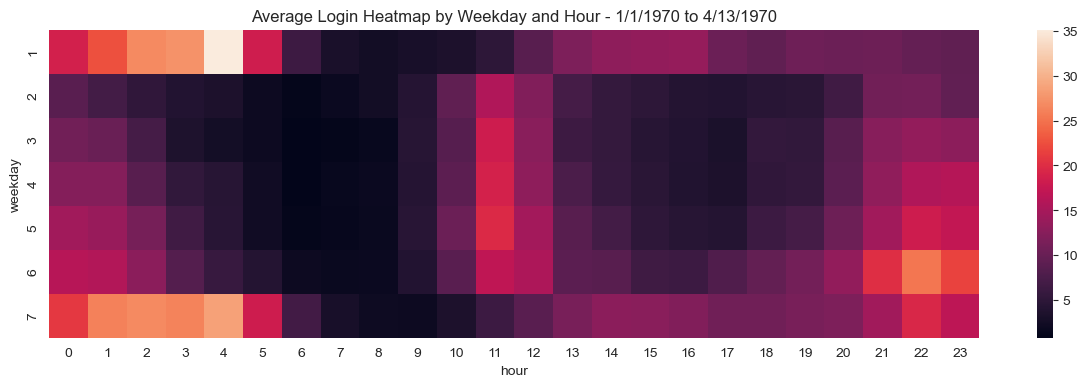

In [62]:
#Create Graph
plt.figure(figsize=(15,4))

sns.heatmap(out)

plt.title('Average Login Heatmap by Weekday and Hour - 1/1/1970 to 4/13/1970')

plt.show()

Very interesting - peaks during th week appear to be more in the middle of the day or after 8-9PM. But the weekends, which we know are busier overall, peak early in the morning between midnight and 5AM.

We can do another view that's less compact, but offer anothe way of looking at this.

### Weekday Line Graphs